In [3]:
# import libraries

'''
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer
'''

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# These are all the imports needed for the assignment
%matplotlib inline

# Import nltk package (Natural Language Toolkit)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

# scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [4]:
# Download the NLTK English tokenizer and the stopwords of all languages
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sukan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sukan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

client = boto3.client(
    's3',
    aws_access_key_id = 'sukiK@2002',
    aws_secret_access_key = 'sukik',
    region_name = 'ap-west-1'
)

In [5]:
files = ['amazon_reviews_us_Electronics_v1_00.tsv', \
         'amazon_reviews_us_Gift_Card_v1_00.tsv', \
         'amazon_reviews_us_Major_Appliances_v1_00.tsv', \
         'amazon_reviews_us_Office_Products_v1_00.tsv', \
         'amazon_reviews_us_Shoes_v1_00.tsv', \
         'amazon_reviews_us_Toys_v1_00.tsv', \
         'amazon_reviews_us_Watches_v1_00.tsv']

In [6]:
columns = ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']
len(columns)

15

bucket = 'farsdata'
prefix = 'dataFiles'
data_location = 's3://{}/{}/'.format(bucket, prefix)
data_location

one_file = pd.read_csv(data_location + files[0], names = columns, sep = '\t').iloc[1:,:]
one_file.head()

In [8]:
one_file = pd.read_csv('FARS/fars_data/' + files[0], names = columns, sep = '\t').iloc[1:,:]
one_file.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
1,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
2,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
3,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
4,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
5,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


#test.rename(columns=test.iloc[0])
training_data = pd.DataFrame() #initialize an empty dataframe
testing_data = pd.DataFrame()

one_file = pd.read_csv(data_location + files[1], names = columns, sep = '\t').iloc[1:,:]

In [10]:
one_file.shape

(1440998, 15)

In [11]:
def convert_to_int(x):
    return int(float(x))

In [12]:
#convert all mixed datatypes --> string objects (unable to convert to int)
one_file['customer_id'] = one_file['customer_id'].apply(int) #1
one_file['product_parent'] = one_file['product_parent'].apply(int) #4
one_file['star_rating'] = one_file['star_rating'].apply(int) #7
one_file['helpful_votes'] = one_file['helpful_votes'].apply(int) #8
one_file['total_votes'] = one_file['total_votes'].apply(int) #9

In [13]:
one_file.isnull().sum().sort_values(ascending=False)

review_body          88
review_date          13
review_headline       6
marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         0
product_category      0
star_rating           0
helpful_votes         0
total_votes           0
vine                  0
verified_purchase     0
dtype: int64

In [14]:
one_file.dropna(inplace=True) #drop all of the missing values
one_file.isnull().sum().sort_values(ascending=False)

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
dtype: int64

for i in range(0, 3):
    print(i)
    model_data = pd.read_csv(data_location + files[i], names = columns, sep = '\t')
    
    train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
    print(train_data.shape, test_data.shape)
    
    training_data.append(train_data, ignore_index=True)
    testing_data.append(test_data, ignore_index=True)

In [15]:
#there may be tabs in the review that is what is leading to the excluded cases when converting to df

'''
train_data['verified_purchase'].value_counts()
test_data['verified_purchase'].value_counts()
'''

one_file.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
1,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
2,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
3,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
4,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
5,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


#to check te datatypes within each column

print(train_data.applymap(type))
data_types = train_data.applymap(type)

In [16]:
#the number of customers that gave multiple reviews
#may be valueable to investigate
one_file.groupby('customer_id').count()['marketplace'].sort_values(ascending = False).value_counts()

1      872989
2      128555
3       38007
4       15081
5        7263
        ...  
62          1
35          1
52          1
48          1
147         1
Name: marketplace, Length: 67, dtype: int64

In [17]:
one_file['star_rating'].value_counts()

5    879526
4    223277
1    158342
3    104102
2     75644
Name: star_rating, dtype: int64

### Sentiment Analysis

In [18]:
#df is all data other than rating 3
df = one_file[one_file['star_rating'] != 3]

In [19]:
df['star_rating'].value_counts()

5    879526
4    223277
1    158342
2     75644
Name: star_rating, dtype: int64

In [20]:
df['positively_rated'] = np.where(df['star_rating'] > 3, 1, 0)

In [21]:
df['positively_rated'].value_counts()

1    1102803
0     233986
Name: positively_rated, dtype: int64

<AxesSubplot:xlabel='positively_rated', ylabel='count'>

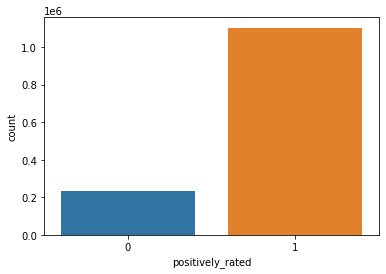

In [22]:
sns.countplot(df['positively_rated'])

##### On all of the data

In [23]:
train_data, test_data = np.split(one_file.sample(frac=1, random_state=1729), [int(0.7 * len(one_file))])
print(train_data.shape, test_data.shape)

(1008623, 15) (432268, 15)


In [24]:
X_train = train_data['review_body']
X_train.iloc[0] #to_frame()

'Fits well, works, stays put even during vigorous activities. Sound very clear.'

In [25]:
Y_train = train_data['star_rating']

In [26]:
X_test = test_data['review_body']
Y_test = test_data['star_rating']

#### TF-IDF - to get predictions of what star rating will be based on text of review

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
vect = TfidfVectorizer().fit(X_train)

In [29]:
len(vect.get_feature_names()) #unique words

138393

In [30]:
X_train_vect = vect.transform(X_train)

In [31]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_vect, Y_train)

LogisticRegression()

In [32]:
predictions = model.predict(vect.transform(X_test))

In [33]:
len(predictions)

432268

###### Confusion Matrix - shows probabilities for whether cat data is predicted correctly

In [34]:
def plot_confusion_matrix(cm, target_names,
                          fname, epoch,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True, target=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    plt.style.use('default')

    # # only true if it weren't normalized:
    # accuracy = np.trace(cm) / float(np.sum(cm))
    # misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm[np.isnan(cm)] = 0.0

    fig = plt.figure(figsize=(5, 4))
    ax = plt.axes()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    if target == "rule-based":
        plt.title(title + ' for rule-based PF')
    else:
        plt.title(title + ' for MLPF at epoch ' + str(epoch))

    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlim(-1, len(target_names))
    plt.ylim(-1, len(target_names))
    plt.xlabel('Predicted label')
    # plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()
    plt.savefig(fname + '.png')
    plt.savefig(fname + '.pdf')
    #plt.close(fig)

    return fig, ax

In [35]:
import sklearn

In [36]:
cn = sklearn.metrics.confusion_matrix(Y_test, predictions, labels=None, sample_weight=None, normalize=None)

(<Figure size 500x400 with 2 Axes>,
 <AxesSubplot:title={'center':'0 for MLPF at epoch ConfusionMatrix.png'}, xlabel='Predicted label', ylabel='True label'>)

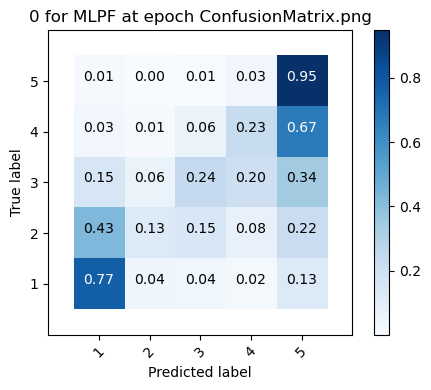

In [37]:
plot_confusion_matrix(cn, [1, 2, 3, 4, 5], "ConfusionMatrixTest", "ConfusionMatrix.png", "0")
#problem where all of the ratings are being predicted as 5

In [38]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()

In [39]:
feature_names[22935]

'b0087oyb38'

In [40]:
list(map(lambda x: feature_names[x], sorted_coef_index[:-11:-1]))

['junk',
 'horrible',
 'garbage',
 'worst',
 'terrible',
 'not',
 'useless',
 'waste',
 'poor',
 'crap']

In [41]:
print("smallest coef", list(map(lambda x: feature_names[x], sorted_coef_index[:10])))

smallest coef ['great', 'love', 'easy', 'excellent', 'perfect', 'nice', 'perfectly', 'best', 'price', 'well']


In [42]:
print("largest coef", list(map(lambda x: feature_names[x], sorted_coef_index[:-11:-1])))

largest coef ['junk', 'horrible', 'garbage', 'worst', 'terrible', 'not', 'useless', 'waste', 'poor', 'crap']


### SVM Notes

- **Bag of Words (BoW)**
        - BoW encodes an input sentence as the frequency of each word in the sentence. 
        - In this approach, all words contribute equally to the feature vectors.
- **Term Frequency - Inverse Document Frequency (TF-IDF)**
        - TF-IDF is a measure of how important each term is to a specific document, as compared to an overall corpus. 
        - TF-IDF encodes each word as its frequency in the document of interest, divided by a measure of how common the word is across all documents (the corpus).
        - Using this approach, each word contributes differently to the feature vectors.
        - The assumption behind using TF-IDF is that words that appear commonly everywhere are not that informative about what is specifically interesting about a document of interest, so it is tuned to representing a document in terms of the words it uses that are different from other documents. 

- To compare those 2 methods, we will first apply them on the same dataset to analyse sentiment (how positive or negative a text is). In order to make the comparison fair, an **SVM (support vector machine)** classifier will be used to classify positive reviews and negative reviews.

- SVM is a simple yet powerful and interpretable linear model. To use it as a classifier, we need to have at least 2 splits of the data: training data and test data. The training data is used to tune the weight parameters in the SVM to learn an optimal way to classify the training data. We can then test this trained SVM classifier on the test data, to see how well it works on data that the classifier has not seen before. 

In [43]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,positively_rated
1,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31,1
2,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31,1
3,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31,1
4,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31,0
5,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31,1


We will now create a CountVectorizer object to transform the text data into vectors with numerical values.

To do so, we will initialize a CountVectorizer object, and name it as vectorizer.

4 arguments to initialize a CountVectorizer:

* analyzer: 'word'
 Specify to analyze data from word-level.
 
* max_features: 2000
 Set a max number of unique words.
 
* tokenizer: word_tokenize
 Set to tokenize the text data by using the word_tokenizer from NLTK .
 
* stop_words: stopwords.words('english')
 Set to remove all stopwords in English. We do this since they generally don't provide useful discriminative information.

In [44]:
vectorizer = CountVectorizer(
    #sublinear_tf=True,
    analyzer='word',
    max_features=2000,
    tokenizer=word_tokenize,
    stop_words=stopwords.words("english")
)

In [45]:
assert vectorizer.analyzer == 'word'
assert vectorizer.max_features == 2000
assert vectorizer.tokenizer == word_tokenize
assert vectorizer.stop_words == stopwords.words('english')
assert hasattr(vectorizer, "fit_transform")

In [46]:
GGR_X = vectorizer.fit_transform(df["review_body"]).toarray()

In [47]:
GGR_Y = df['positively_rated']

Now, we'll instead use sklearn's train_test_split() function here to define our train and test set. Store train data (predictors) into MR_train_X and labels (outcomes) into MR_train_Y. Similarly, store test data into MR_test_X and test labels into MR_test_Y.
- earlier used numpy's np.split in order to replicate this function
- test_size = 0.2 (allocating 20% of data in df to the testing datasets)

In [48]:
GGR_train_X, GGR_test_X, GGR_train_Y, GGR_test_Y = train_test_split(GGR_X, GGR_Y, test_size = 0.2, random_state = 200)
print(GGR_train_X.shape[0])
print(GGR_train_Y.shape[0])

1069431
1069431


In [49]:
#This function will initialize and train a SVM classifier
def train_SVM(X, y, kernel='linear'):
# YOUR CODE HERE
    clf = SVC(kernel = kernel)
    clf.fit(X, y)
    
    return clf

In [50]:
GGR_clf = train_SVM(GGR_train_X, GGR_train_Y)

MemoryError: Unable to allocate 15.9 GiB for an array with shape (1069431, 2000) and data type float64

In [ ]:
GGR_predicted_train_Y = MR_clf.predict(GGR_train_X)
GGR_predicted_test_Y = MR_clf.predict(GGR_train_Y)

In [ ]:
print(classification_report(GGR_train_Y,GGR_predicted_train_Y))

In [ ]:
print(classification_report(GGR_test_Y, GGR_predicted_test_Y))

KNN

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

find percentages for the body -- text and display those in a column -- act as labels for the percent positivity of the review body and header themselves

In [54]:
imp_col = df[['verified_purchase', 'customer_id', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'review_headline', 'review_body', 'positively_rated']]

In [66]:
imp_col.dtypes

verified_purchase    object
customer_id           int64
star_rating           int64
helpful_votes         int64
total_votes           int64
vine                 object
review_headline      object
review_body          object
positively_rated      int32
dtype: object

In [69]:
#need to replace review_body and review_headline with percentages for sentiment -- easier to use for classification
#vine needs to be converted to a yes/no binary column similar to how positively rated was determined
#use original dataset with rating 3 available
X = imp_col.iloc[:, [2, 3, 4, 8]].values
y = imp_col.iloc[:, 0].values

#Since our dataset containing character variables we have to encode it using LabelEncoder

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[:,2] = le.fit_transform(X[:,2])

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [71]:
# Next, we are doing feature scaling to the training and test set of independent variables for reducing the size to smaller values
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [72]:
from sklearn.neighbors import KNeighborsClassifier

#we are using 
#5 neighborhood points are required for classifying a given point -- distance metric is using the minkonowski equation
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [73]:
y_pred = classifier.predict(X_test)

In [74]:
#We can evaluate our model using the confusion matrix and accuracy score by comparing the predicted and actual test values

from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test,y_pred)

In [77]:
print(cm)

[[   463  25143]
 [   949 240803]]


In [76]:
print(ac)

0.9024080072412272


In [75]:
#Can see the model performance and add more features accordingly -- 
#would be good if the performance is greater than 85%